# HW 4 : Clustering 

In this HW we will use K-means variants on Fisher's Iris dataset

In [181]:
# relevant packges
%matplotlib inline
from sklearn import datasets, cluster
import numpy as np
from numpy.linalg import norm
import copy
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [9]:
# load data
iris = datasets.load_iris()

X_iris = iris.data
y_iris = iris.target    

In [3]:
# Check data type and dim
print (str(type(X_iris)) + 'dimensions: '+str(X_iris.shape))
print (str(type(y_iris)) + 'dimensions: '+str(y_iris.shape))
print (X_iris[1,:])

<type 'numpy.ndarray'>dimensions: (150L, 4L)
<type 'numpy.ndarray'>dimensions: (150L,)
[ 4.9  3.   1.4  0.2]


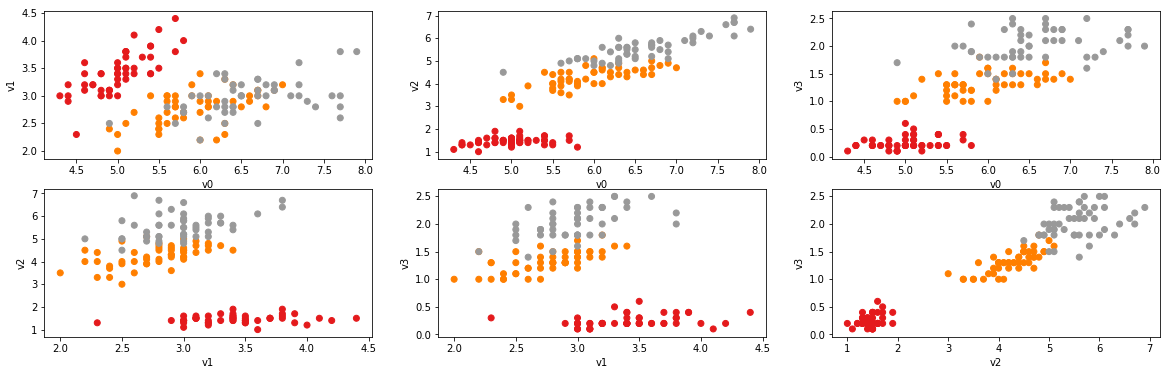

In [4]:
# Visualize 2d projections
fig = plt.figure(1, figsize=(20, 6))
itr = 1
for i in xrange(0,4):
    for j in xrange(i+1,4):
        plt.subplot(2,3,itr)
        plt.scatter(X_iris[:,i], X_iris[:,j], c=y_iris, cmap=plt.cm.Set1)
        plt.xlabel('v'+str(i))
        plt.ylabel('v'+str(j))
        itr+=1

(150L, 3L)


[]

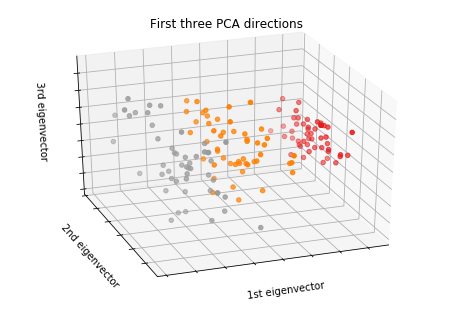

In [5]:
# Question 1 - fill in the code as required
fig = plt.figure(2)
X_reduced = np.zeros((y_iris.size,3))
#  Obtain first 3 PCA directions by using PCA method fit_transform 
######## Your Code Here ##########

X_reduced = PCA(n_components=3).fit_transform(X_iris)

##################################
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y_iris,
           cmap=plt.cm.Set1)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

In [95]:
# Question 2 - fill in the code as required

######## Your Code Here ##########
# Cluster via KMeans from cluster
# tweak parameters/ use a grid search for best results

k_means = cluster.KMeans(n_clusters=len(set(y_iris)))

# We're tweaking parameters based on the documentaion found here:
# http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

##################################
# cluster
k_means.fit(X_iris) 
# obtain labels
sk_k_means_labels = k_means.labels_

In [13]:
# Question 3 - write a function that computes the number of correct labels
def correctLabelNum(y_iris,labels):
    
    SAMPLE = 50
    #Our strategy is to pick #SAMPLE random elements with the same label,
    #and map their label to the predicted label which holds the most of them.
    allIndices = []
    
    for label in [0,1,2]:
        
        indices = np.nonzero(y_iris == label)
        allIndices.append(indices)
    
    selectedIndices = [np.random.choice(labelsList[0],SAMPLE) for labelsList in allIndices]
    
    #Now after we chose the random elements, find the cluster in which most of them are located.
    actualLabels = [] #These is the mapping to the clustering labels.
    
    for indices in selectedIndices:
        curLabels = np.take(labels,indices)
        actualLabels.append(np.argmax(np.bincount(curLabels)))  
    
    labels = [actualLabels[x] for x in labels]
    
    return sum(y_iris == labels)

In [82]:
# check precentage of correct classification

print "sklearn K-means classified " + str(correctLabelNum(y_iris,sk_k_means_labels))+ ":"+ str(y_iris.size)+ " correctly"

sklearn K-means classified 134:150 correctly


In [26]:
# Justified the parameters selection:

def testKMeans(k_means):
   
    # cluster
    k_means.fit(X_iris) 
    # obtain labels
    sk_k_means_labels = k_means.labels_
    print "sklearn K-means classified " + str(correctLabelNum(y_iris,sk_k_means_labels))+ ":"+ str(y_iris.size)+ " correctly"
    
    
kMeansList = [
    cluster.KMeans(n_clusters=len(set(y_iris))),
    cluster.KMeans(n_clusters=len(set(y_iris)), n_init=20),
    cluster.KMeans(n_clusters=len(set(y_iris)), n_init=30),
    cluster.KMeans(n_clusters=len(set(y_iris)), n_init=40),
    cluster.KMeans(n_clusters=len(set(y_iris)), max_iter=600),
    cluster.KMeans(n_clusters=len(set(y_iris)), max_iter=1200),
    cluster.KMeans(n_clusters=len(set(y_iris)), init='random'),
    cluster.KMeans(n_clusters=len(set(y_iris)), tol=1e-12, max_iter=1200)   
]

for i,k in enumerate(kMeansList):
    print 'checking ',i,'res is:'
    testKMeans(k)

checking  0 res is:
sklearn K-means classified 134:150 correctly
checking  1 res is:
sklearn K-means classified 2:150 correctly
checking  2 res is:
sklearn K-means classified 134:150 correctly
checking  3 res is:
sklearn K-means classified 134:150 correctly
checking  4 res is:
sklearn K-means classified 134:150 correctly
checking  5 res is:
sklearn K-means classified 2:150 correctly
checking  6 res is:
sklearn K-means classified 14:150 correctly
checking  7 res is:
sklearn K-means classified 134:150 correctly


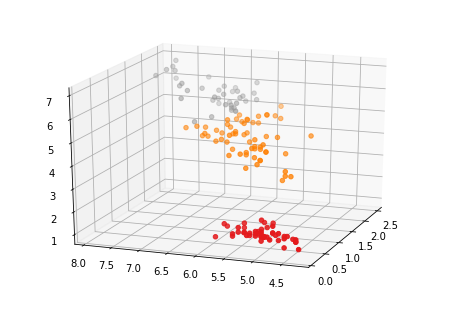

In [29]:
# Visualize clustering by sklearn K-means
fig = plt.figure(3)
ax = Axes3D(fig, elev=20, azim=200)
ax.scatter(X_iris[:,3], X_iris[:,0], X_iris[:,2], c=sk_k_means_labels,
           cmap=plt.cm.Set1)

In [184]:
# Utility functions for the clustering algorithms' implementation:
def pick_random_centers(num_centers, X):
    random_init = np.random.choice(range(len(X)), num_centers)
    R = X[random_init,:]
    return R

def calculate_distances_mat(centers, X):
    distances_mat = np.zeros((X.shape[0], centers.shape[0]))
    for i,xi in enumerate(X):
        for j,yj in enumerate(centers):
            distances_mat[i][j] = np.square(norm(xi-yj))
    return distances_mat

def calculate_P_mat(distances_mat):
    num_data = distances_mat.shape[0]
    num_centers = distances_mat.shape[1]
    
    P_mat = np.zeros((num_data, num_centers))
    for i in range(num_data):
        i_min = min(distances_mat[i,:])
        for j in range(num_centers):
            if(distances_mat[i][j] == i_min):
                P_mat[i][j] = 1
            else:
                P_mat[i][j] = 0
    return P_mat

def calculate_soft_P_mat(distances_mat, beta):
    num_data = distances_mat.shape[0]
    num_centers = distances_mat.shape[1]
    
    P_mat = np.zeros((num_data, num_centers))
    
    for i in range(num_data):
        Z = 0
        for j in range(num_centers):
            Z += math.exp((-beta)*distances_mat[i][j])
            
        for j in range(num_centers):
            P_mat[i][j] = (math.exp((-beta)*distances_mat[i][j]) / float(Z))
    return P_mat

def calculate_centers(P_mat, X):
    num_centers = P_mat.shape[1]
    R = np.zeros((num_centers, X.shape[1]))

    for j in range(num_centers):
        x_sum = 0;
        total_sum = 0;
        for i,xi in enumerate(X):
            x_sum += P_mat[i][j] * xi
            total_sum += P_mat[i][j]
        R[j] = (x_sum / float(total_sum))
    return R

def calculate_old_and_new_distances(X, R, P_mat, distances_mat):
    R_updated_distances = 0
    R_distances = 0
    for i,xi in enumerate(X):
        for j,yj in enumerate(R):
            R_updated_distances += P_mat[i][j] * distances_mat[i][j]
            R_distances += P_mat[i][j] * np.square(norm(xi-yj)) 
    return R_updated_distances, R_distances

In [178]:
# Question 4 - Implement K-means by yourself (don't use any k-mean libarary code )
#              your implementation outputs should be consisted with sklearn K-means
class K_means_vanilla:
    def __init__(self,n_clusters=1):
        self.n_clusters = n_clusters
        ######## Your Code Here ##########
        self.epsilon = 1e-4
        self.max_iterations = 300;
        self.R = np.zeros(self.n_clusters)        
        
        ##################################
        
    def fit(self,X):
        ######## Your Code Here ##########
        
        # Try 10 times to run the k-means algorithm, each time with random initial centers,
        # and return the best result:
        
        # create variables and matrixes for later use:
        num_data = X.shape[0]
        num_centers = self.n_clusters
        distances_mat = np.zeros((num_data, num_centers))
        self.P_mat = np.zeros((num_data, num_centers))
        
        best_R_distances = -1 ;
        self.P_mat_best = np.zeros((num_data, num_centers))
        
        for i in range(10):
        
            # init random centers, by choosing random X vectors:
            self.R = copy.deepcopy(pick_random_centers(self.n_clusters, X))

            # iterate to find the best centers:
            for i in range(self.max_iterations):
                self.R_updated = copy.deepcopy(self.R[:,:])

                # calculate the matrix P:
                distances_mat = copy.deepcopy(calculate_distances_mat(self.R_updated, X))
                
                self.P_mat = copy.deepcopy(calculate_P_mat(distances_mat))

                # calculate the new centers:
                self.R = copy.deepcopy(calculate_centers(self.P_mat, X))
                
                # calculate improvement:
                R_updated_distances, R_distances = calculate_old_and_new_distances(X, self.R, self.P_mat, distances_mat)

                # if the improvement is smaller then epsilon, stop iterating:               
                if (R_updated_distances - R_distances < self.epsilon):
                    break;
            if ((R_distances < best_R_distances) | (best_R_distances == -1)):
                best_R_distances = R_distances
                self.P_mat_best = copy.deepcopy(self.P_mat[:,:])
            
        return self.R          

        ##################################
        
        
    def labels(self):
        ######## Your Code Here ##########
        num_data = self.P_mat_best.shape[0]
        self.labels = np.zeros((num_data))
        for i in range(num_data):
            for j,yj in enumerate(self.P_mat_best[i,:]):
                if yj == 1:
                    self.labels[i] = j
        
        return self.labels.astype(int)        

        ##################################

Vanilla K-means classified 134:150 correctly


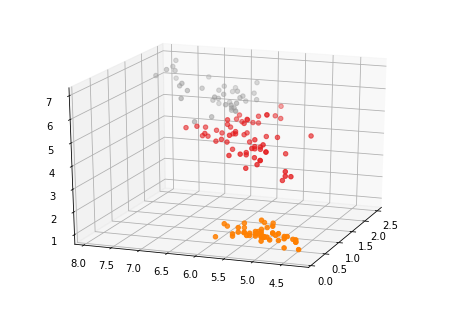

In [180]:
# Run vanilla K-means on data 
my_K_means_vanilla = K_means_vanilla(n_clusters = 3)
my_K_means_vanilla.fit(X_iris)
vanill_my_k_means_labels = my_K_means_vanilla.labels()

# Visualize vanilla K means clustering
fig = plt.figure(4)
ax = Axes3D(fig, elev=20, azim=200)
ax.scatter(X_iris[:,3], X_iris[:,0], X_iris[:,2], c=vanill_my_k_means_labels,
           cmap=plt.cm.Set1)

# check precentage of correct classification
print "Vanilla K-means classified " + str(correctLabelNum(y_iris,vanill_my_k_means_labels))+ ":"+ str(y_iris.size)+ " correctly"

In [ ]:
# Question 5 - Implement K-Medoids (don't use any k-mean libarary code)
class K_Medoids:
   def __init__(self,n_clusters=1):
      self.n_clusters = n_clusters
        ######## Your Code Here ##########
      

        ##################################
   def fit(self,X):
        ######## Your Code Here ##########


        ##################################
   def labels(self):
        ######## Your Code Here ##########


        ##################################


In [ ]:
# Run K-Medoids on data 
my_K_Medoids = K_Medoids(n_clusters = 3)
my_K_Medoids.fit(X_iris)
my_K_Medoids_labels = my_K_Medoids.labels()

# Visualize vanilla K means clustering
fig = plt.figure(4)
ax = Axes3D(fig, elev=20, azim=200)
ax.scatter(X_iris[:,3], X_iris[:,0], X_iris[:,2], c=my_K_Medoids_labels,
           cmap=plt.cm.Set1)

# check precentage of correct classification
print "K-Medoids classified " + str(correctLabelNum(y_iris,my_K_Medoids_labels))+ ":"+ str(y_iris.size)+ " correctly"

In [190]:
# Question 6 - Implement soft K-Means (don't use any k-mean libarary code)
class soft_K_Means:
    def __init__(self,n_clusters=1):
        self.n_clusters = n_clusters
        ######## Your Code Here ##########
        self.epsilon = 1e-4
        self.max_iterations = 300;
        self.beta = 0.6  # tradeoff between belonging to the closest center, and belonging to ,multiple centers
        self.R = np.zeros(self.n_clusters)

        ##################################
        
    def fit(self,X):
        ######## Your Code Here ##########
        
        # Try 10 times to run the soft-k-means algorithm, each time with random initial centers,
        # and return the best result:
        
        # create variables and matrixes for later use:
        num_data = X.shape[0]
        num_centers = self.n_clusters
        distances_mat = np.zeros((num_data, num_centers))
        self.P_mat = np.zeros((num_data, num_centers))
        
        best_R_distances = -1 ;
        self.P_mat_best = np.zeros((num_data, num_centers))
        
        for i in range(10):
        
            # init random centers, by choosing random X vectors:
            self.R = copy.deepcopy(pick_random_centers(self.n_clusters, X))

            # iterate to find the best centers:
            for i in range(self.max_iterations):
                self.R_updated = copy.deepcopy(self.R[:,:])

                # calculate the soft matrix P:
                distances_mat = copy.deepcopy(calculate_distances_mat(self.R_updated, X))
                
                self.P_mat = copy.deepcopy(calculate_soft_P_mat(distances_mat, self.beta))

                # calculate the new centers:
                self.R = copy.deepcopy(calculate_centers(self.P_mat, X))
                
                # calculate improvement:
                R_updated_distances, R_distances = calculate_old_and_new_distances(X, self.R, self.P_mat, distances_mat)

                # if the improvement is smaller then epsilon, stop iterating:               
                if (R_updated_distances - R_distances < self.epsilon):
                    break;
            if ((R_distances < best_R_distances) | (best_R_distances == -1)):
                best_R_distances = R_distances
                self.P_mat_best = copy.deepcopy(self.P_mat[:,:])
            
        return self.R 

        ##################################
        
    def labels(self):
        ######## Your Code Here ##########
        num_data = self.P_mat_best.shape[0]
        self.labels = np.zeros((num_data))
        for i in range(num_data):
            self.labels[i] = np.argmax(np.array(self.P_mat_best[i,:]))
        
        return self.labels.astype(int)

        ##################################

soft K-means classified 134:150 correctly


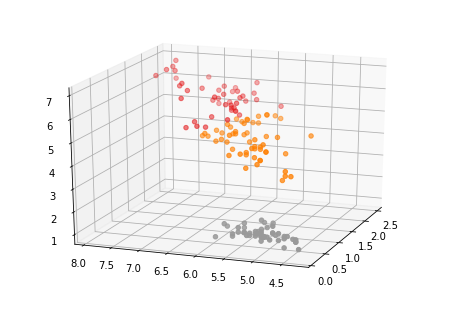

In [191]:
# Run soft K-Means on data 
my_soft_K_Means = soft_K_Means(n_clusters = 3)
my_soft_K_Means.fit(X_iris)
my_soft_K_Means_labels = my_soft_K_Means.labels()

# Visualize soft K means clustering
fig = plt.figure(4)
ax = Axes3D(fig, elev=20, azim=200)
ax.scatter(X_iris[:,3], X_iris[:,0], X_iris[:,2], c=my_soft_K_Means_labels,
           cmap=plt.cm.Set1)

# check precentage of correct classification
print "soft K-means classified " + str(correctLabelNum(y_iris,my_soft_K_Means_labels))+ ":"+ str(y_iris.size)+ " correctly"